In [ ]:
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import h5py
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, TimeoutError

class SudokuGenerator:
	def __init__(self):
		self.base = 3
		self.side = self.base * self.base

	def solve(self, grid, row, col, num):
		for n in range(1, self.side + 1):
			if self.is_safe(grid, n, row, col):
				grid[row][col] = n
				next_row, next_col = self.find_empty(grid)
				if next_row is None:
					return True
				if self.solve(grid, next_row, next_col, None):
					return True
				grid[row][col] = 0
		return False

	def is_safe(self, grid, num, row, col):
		return (num not in grid[row] and
				num not in grid[:, col] and
				num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
							   col // self.base * self.base: (col // self.base + 1) * self.base])

	def find_empty(self, grid):
		for i in range(self.side):
			for j in range(self.side):
				if grid[i][j] == 0:
					return i, j
		return None, None

	def generate_solution_grid(self):
		grid = torch.zeros((self.side, self.side), dtype=torch.int8)
		self.fill_all_boxes(grid)
		self.solve(grid, 0, 0, None)
		return grid

	def fill_all_boxes(self, grid):
		for i in range(self.base):
			for j in range(self.base):
				self.fill_box(grid, i * self.base, j * self.base)

	def fill_box(self, grid, row, col):
		numbers = list(range(1, self.side + 1))
		random.shuffle(numbers)
		for i in range(self.base):
			for j in range(self.base):
				grid[row + i][col + j] = numbers.pop()

	def remove_numbers(self, grid, num_holes):
		puzzle = grid.clone()
		cells = list(range(self.side * self.side))
		random.shuffle(cells)
		for index in cells[:num_holes]:
			row, col = divmod(index, self.side)
			puzzle[row][col] = 0
		return puzzle

	def generate_single_puzzle(self):
		solution = self.generate_solution_grid()
		num_holes = random.randint(12, 48)
		puzzle = self.remove_numbers(solution, num_holes)
		return puzzle, solution

	def generate_puzzles(self, num_puzzles=5, max_workers=20):
		puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
		solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

		with ThreadPoolExecutor(max_workers=max_workers) as executor:
			futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
			for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
				try:
					puzzle, solution = future.result(timeout=6)
					puzzles[idx] = puzzle
					solutions[idx] = solution
				except TimeoutError:
					print("Puzzle", idx + 1, "generation timed out. Retrying...")

		return puzzles, solutions

	def change_to_one_hot(self, data):
		one_hot_list = []
		for n in range(len(data)):
			one_hot = torch.zeros(9, 9, 10, dtype=torch.float32)
			for i in range(9):
				for j in range(9):
					value = data[n][i][j]
					if value > 0:
						one_hot[i][j][value] = 1.0
			one_hot_list.append(one_hot)
		return torch.stack(one_hot_list)

	def save_dataset(self, puzzles, solutions, path='sudoku_dataset.pt', one_hot=False):
		os.makedirs(os.path.dirname(path), exist_ok=True)

		if one_hot:
			puzzles = self.change_to_one_hot(puzzles)
			solutions = self.change_to_one_hot(solutions)

		if path.endswith('.pt'):
			torch.save({'puzzles': puzzles, 'solutions': solutions}, path)
			print("Dataset saved as PyTorch file:", path)

		elif path.endswith('.h5'):
			with h5py.File(path, 'w') as hf:
				hf.create_dataset('puzzles', data=puzzles.numpy())
				hf.create_dataset('solutions', data=solutions.numpy())
			print("Dataset saved as HDF5 file:", path)

		else:
			raise ValueError("Unsupported file format. Use '.pt' or '.h5'.")

	def load_dataset(self, path='sudoku_dataset.pt'):
		if path.endswith('.pt'):
			data = torch.load(path)
			print("Dataset loaded from PyTorch file.")
			return data['puzzles'], data['solutions']

		elif path.endswith('.h5'):
			with h5py.File(path, 'r') as hf:
				puzzles = torch.tensor(hf['puzzles'][:])
				solutions = torch.tensor(hf['solutions'][:])
			print("Dataset loaded from HDF5 file.")
			return puzzles, solutions

		else:
			raise ValueError("Unsupported file format. Use '.pt' or '.h5'.")



In [8]:
if __name__ == "__main__":
	gen = SudokuGenerator()
	puzzles, solutions = gen.generate_puzzles(num_puzzles=100)

	# Save in one-hot encoded format
	gen.save_dataset(puzzles, solutions, path='data/sudoku_onehot.pt', one_hot=True)

	# Save in regular int8 format
	gen.save_dataset(puzzles, solutions, path='data/sudoku.pt', one_hot=False)

	# Load dataset
	p, s = gen.load_dataset('data/sudoku.pt')


Generating Puzzles: 100%|██████████| 100/100 [00:00<00:00, 164.70it/s]


Dataset saved as PyTorch file: data/sudoku_onehot.pt
Dataset saved as PyTorch file: data/sudoku.pt
Dataset loaded from PyTorch file.


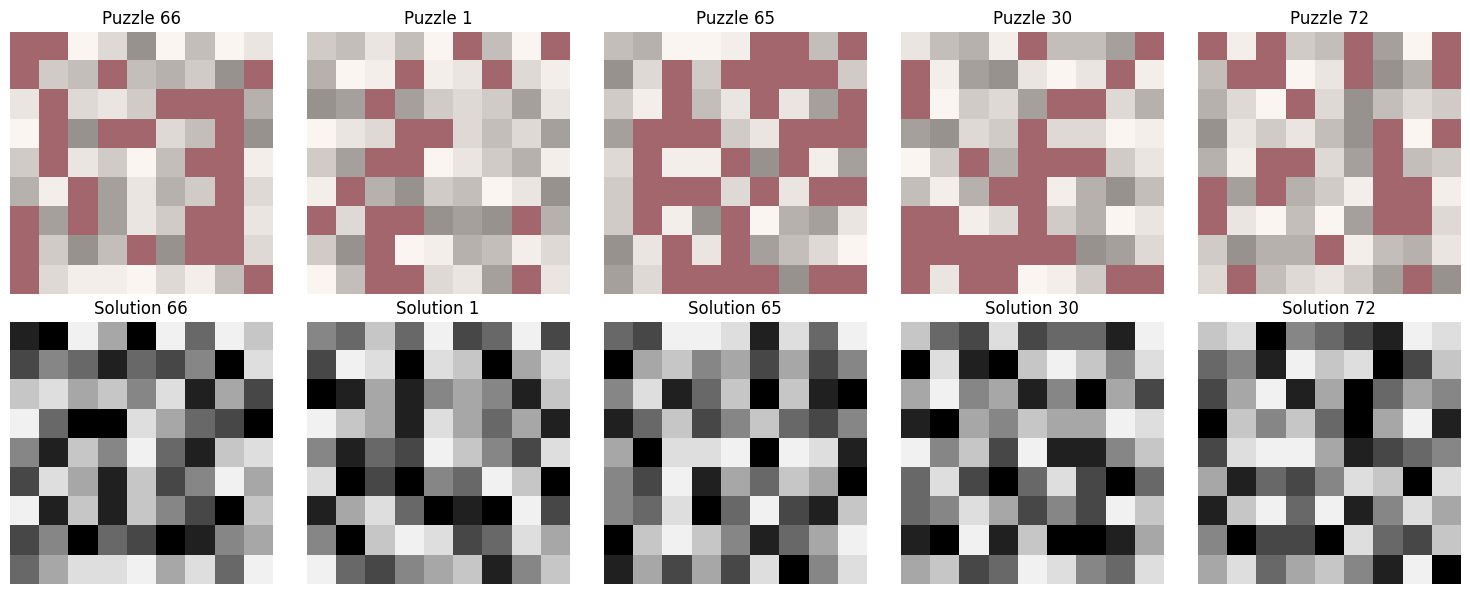

In [13]:


def plot_sudoku(puzzles, solutions, n=5):
	# Wybierz n unikalnych indeksów
	indices = random.sample(range(len(puzzles)), n)

	fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))

	for i, idx in enumerate(indices):
		puzzle = puzzles[idx].numpy()
		solution = solutions[idx].numpy()

		# Rysuj puzzle
		ax = axes[0, i]
		mask = np.zeros_like(puzzle)
		mask[puzzle == 0] = 1  # Maskowanie zer (puste pola)

		ax.imshow(puzzle, cmap='Greys', vmin=0.5, vmax=9)
		ax.imshow(mask, cmap='Reds', alpha=0.6, vmin=0, vmax=1)
		ax.set_title(f'Puzzle {idx + 1}')
		ax.axis('off')

		# Rysuj solution
		ax = axes[1, i]
		ax.imshow(solution, cmap='Greys', vmin=0, vmax=9)
		ax.set_title(f'Solution {idx + 1}')
		ax.axis('off')

	plt.tight_layout()
	plt.show()
plot_sudoku(puzzles, solutions, n=5)

